# 2.155/6 Challenge Problem 2
<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

<font size="1">
  Pixel Art by J. Shung. </font>

# TODO
- Design new grids using GAs and rules of observations how advisors work
- Improve feature engineering
- Select better grids for diversity (not just off top minimum scores)

In [ ]:
from utils_public import *
import numpy as np
import pandas as pd
import os, time
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.base import clone

from autogluon.tabular import TabularPredictor

# This was needed to prevent several of the models from locking up when loading from autogluon saves
os.environ.update({"OMP_NUM_THREADS":"1","MKL_NUM_THREADS":"1","OPENBLAS_NUM_THREADS":"1"})

## Creating Grids

In [122]:
grids = load_grids()
ratings = np.load("datasets/scores.npy")
ratings_df = pd.DataFrame(ratings, columns = ["Wellness", "Tax", "Transportation", "Business"])

In [123]:
# TODO generate new grids with genetic algorithms?

## Evaluating Grids

In [ ]:
## FEATURE ENGINEERING ##

from scipy import ndimage

def interface_count(grid, a, b):
    # 4-neighbor interfaces between labels a and b
    g = grid
    right = (g[:, :-1] == a) & (g[:, 1:] == b)
    right |= (g[:, :-1] == b) & (g[:, 1:] == a)
    down = (g[:-1, :] == a) & (g[1:, :] == b)
    down |= (g[:-1, :] == b) & (g[1:, :] == a)
    return right.sum() + down.sum()

def connectivity_features(grid, label):
    mask = (grid == label).astype(np.uint8)
    if mask.sum() == 0:
        return 0, 0, 0.0
    struct = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)  # 4-neighborhood
    comp, n = ndimage.label(mask, structure=struct)
    sizes = np.bincount(comp.ravel())[1:]
    return n, sizes.max(), sizes.mean()

def symmetry_scores(grid):
    h = 1.0 - (np.mean(grid == np.fliplr(grid)))
    v = 1.0 - (np.mean(grid == np.flipud(grid)))
    return h, v

def cooccurrence_4n(grid, n_labels=5):
    # counts of adjacent pairs (unordered) across 4-neighbors
    counts = np.zeros((n_labels, n_labels), dtype=np.int32)
    # right neighbors
    a, b = grid[:, :-1], grid[:, 1:]
    for i in range(n_labels):
        for j in range(i, n_labels):
            c = ((a == i) & (b == j)) | ((a == j) & (b == i))
            counts[i, j] += c.sum()
            if i != j:
                counts[j, i] = counts[i, j]
    # down neighbors
    a, b = grid[:-1, :], grid[1:, :]
    for i in range(n_labels):
        for j in range(i, n_labels):
            c = ((a == i) & (b == j)) | ((a == j) & (b == i))
            counts[i, j] += c.sum()
            if i != j:
                counts[j, i] = counts[i, j]
    return counts

def feature_eng_adv(grids):
    # grids: (N, 7, 7) int
    N = grids.shape[0]
    feats = []
    for g in grids:
        counts = [(g == k).sum() for k in range(5)]
        props = [c / 49.0 for c in counts]

        # interfaces
        iface = {(i, j): interface_count(g, i, j) for i in range(5) for j in range(i+1, 5)}
        total_iface = sum(iface.values())

        # connectivity for labels 0 and 3 (expand as needed)
        n0, max0, mean0 = connectivity_features(g, 0)
        n3, max3, mean3 = connectivity_features(g, 3)

        # symmetry
        sym_h, sym_v = symmetry_scores(g)

        # center vs border for label 0
        center_mask = np.zeros_like(g, dtype=bool)
        center_mask[2:5, 2:5] = True
        center0 = (g[center_mask] == 0).sum()
        border0 = (g[~center_mask] == 0).sum()

        # interactions
        prop_pairs = [props[i]*props[j] for i in range(5) for j in range(i+1, 5)]
        sdiv = lambda a,b: a / (b + 1e-6)
        largest_ratio_0 = sdiv(max0, counts[0])
        frag_0 = sdiv(n0, counts[0])
        center_ratio_0 = sdiv(center0, center0 + border0)
        iface_density = sdiv(total_iface, 84.0)  # total 4-neighbor edges in 7x7
        iface_03_norm = sdiv(iface[(0,3)], counts[0] + counts[3])
        sym_h_p0 = sym_h * props[0]
        sym_v_p3 = sym_v * props[3]

        feats.append([
            *counts, *props,
            iface[(0,3)], total_iface,
            n0, max0, mean0, n3, max3, mean3,
            sym_h, sym_v,
            center0, border0,
            *prop_pairs,
            largest_ratio_0, frag_0, center_ratio_0,
            iface_density, iface_03_norm,
            sym_h_p0, sym_v_p3
        ])

    features = np.asarray(feats, dtype=np.float32)
    grids_flat = grids.reshape(-1, 49) # flatten the grids
    grids_out = np.hstack([grids_flat, features]) #stack the features horizontally with the flattened grids
    return grids_out.astype(np.float32)
    

def append_district_counts(grids): #performs the feature engineering to add district counts
    grids_flat = grids.reshape(-1, 49) #first flatten the grids

    counts = [np.sum(grids_flat==0, axis=1),
              np.sum(grids_flat==1, axis=1),
              np.sum(grids_flat==2, axis=1),
              np.sum(grids_flat==3, axis=1),
              np.sum(grids_flat==4, axis=1)] #list of 5 length n_grids arrays containing counts of each district
    features = np.stack(counts).T #stack and transpose counts to get n_grids x 5 array
    grids_out = np.hstack([grids_flat, features]) #stack the features horizontally with the flattened grids
    return grids_out.astype(np.float32)



## FITTING REGRESSORS ##
    
def advisor_train(grids, ratings, advisor):
    FE_fn = FE_fns[advisor]
    grids_train, ratings_train = select_rated_subset(grids, ratings[:,advisor]) #gets subset of the dataset rated by advisor
    grids_fa = pd.DataFrame(FE_fn(grids_train)).astype(np.float32)

    all_train = grids_fa.copy().astype(np.float32)
    all_train["label"] = ratings_train

    predictor = TabularPredictor(label='label',
                                 problem_type='regression',
                                 verbosity=2,
                                 eval_metric='r2')
    predictor.fit(all_train, presets='medium', time_limit=60)
    predictor.delete_models(models_to_keep='best')

    # Compute and display permutation feature importance on training data (NOT WORKING)
    # fi = predictor.feature_importance(all_train, subsample_size=2000, time_limit=30)
    # fi_top = fi.sort_values('importance', ascending=False).head(25)
    # print("Top feature importances:")
    # print(fi_top[['importance', 'stddev', 'p_value']])
    # fi.to_csv(predictor.path + f"/feature_importance_advisor{advisor}.csv")

    return predictor


def advisor_predict(grids, advisor):
    print(f"Predicting Advisor {advisor}...")
    FE_fn = FE_fns[advisor]
    predictor = TabularPredictor.load("AutogluonModels/"+models[advisor])
    print('  Feature engineering...')
    t0 = time.time()
    grids_FE = pd.DataFrame(FE_fn(grids)).astype(np.float32) #feature engineering on full dataset
    print(f"  Ran for {time.time()-t0:.1f}s")
    print(f"  Evaluating grids...")
    t0 = time.time()
    predictions = predictor.predict(grids_FE[:2000]) #predict on full dataset
    t1 = time.time()
    est_run_time = (t1-t0)*len(grids)/2000
    print(f"  Estimate run time: {est_run_time:.1f}s")
    predictions = pd.concat([predictions, predictor.predict(grids_FE[2000:])]) #predict on full dataset
    print(f"  Ran for {time.time()-t1:.1f}s")

    return predictions

models = ["ag-20251022_040544",
          "ag-20251021_231536",
          "ag-20251022_044013",
          "ag-20251021_231705",]

#TODO more feature engineering for advisor 0 and 2
FE_fns = [feature_eng_adv,
          append_district_counts,
          feature_eng_adv,
          append_district_counts]

all_predictions = []
for advisor in [0, 1, 2, 3]:
    # advisor_train(grids, ratings, advisor)
    advisor_predictions = advisor_predict(grids[:], advisor)
    all_predictions.append(advisor_predictions)
    all_predictions_array = np.stack(all_predictions).T
    np.save("all_predictions.npy", all_predictions_array)
    print(f"Saved all_predictions with shape {all_predictions_array.shape}")

Predicting Advisor 0...
  Feature engineering...
  Ran for 79.1s
  Evaluating grids...
  Estimate run time: 14.5s
  Ran for 5.6s
Predicting Advisor 1...
  Feature engineering...
  Ran for 0.2s
  Evaluating grids...
  Estimate run time: 3.5s
  Ran for 0.4s
Predicting Advisor 2...
  Feature engineering...
  Ran for 78.8s
  Evaluating grids...
  Estimate run time: 10.4s
  Ran for 4.9s
Predicting Advisor 3...
  Feature engineering...
  Ran for 0.2s
  Evaluating grids...
  Estimate run time: 9.0s
  Ran for 2.5s


Notes about models (20251021)

| Advisor | Model number | OSR2 | Prediction Time |
| :--- | :---: | ---: | ---: | 
| 0 | ag-20251022_040544 | 0.7442 | 7.2s |
| 1 | ag-20251021_231536 | 0.9161 | 0.5s |
| 2 | ag-20251022_044013 | 0.4718 | 3.3s |
| 3 | ag-20251021_231705 | 0.9631 | 2.5s |

In [ ]:
# taken from demo 6 - can this be used here?
# df = pd.DataFrame(Y, columns=["C11", "C12", "C22", "C66", "VF"])
# pairplot = sns.pairplot(df, plot_kws={'s': 3, 'color': 'black', 'alpha': 0.2})
# plt.show()

In [126]:
## Autogluon Model leaderboard
model_root = "AutogluonModels"
model_dirs = sorted([d for d in os.listdir(model_root) if os.path.isdir(os.path.join(model_root, d))])
for d in model_dirs:
    path = os.path.join(model_root, d)
    print("\n" + "="*80)
    print(f"Leaderboard for {d} ({path})")
    print("="*80)
    predictor = TabularPredictor.load(path)
    summary = predictor.fit_summary()


Leaderboard for ag-20251021_231536 (AutogluonModels/ag-20251021_231536)
*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0             CatBoost   0.916089          r2       0.001515  32.244943                0.001515          32.244943            1       True          1
1  WeightedEnsemble_L2   0.916089          r2       0.001725  32.264606                0.000210           0.019663            2       True          2
Number of models trained: 2
Types of models trained:
{'WeightedEnsembleModel', 'CatBoostModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 54 | ['0', '1', '2', '3', '4', ...]
*** End of fit() summary ***

Leaderboard for ag-20251021_231705 (AutogluonModels/ag-20251021_231705)


/Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/.venv/lib/python3.12/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')
/Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/.venv/lib/python3.12/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.963094          r2       0.006976  35.305650                0.000210           0.019047            2       True          4
1             CatBoost   0.957765          r2       0.001353  25.735354                0.001353          25.735354            1       True          1
2              XGBoost   0.955250          r2       0.002980   1.102729                0.002980           1.102729            1       True          2
3       NeuralNetTorch   0.946084          r2       0.002433   8.448519                0.002433           8.448519            1       True          3
Number of models trained: 4
Types of models trained:
{'TabularNeuralNetTorchModel', 'WeightedEnsembleModel', 'CatBoostModel', 'XGBoostModel'}
Bagging used: False 
Multi-layer stack-ensembl

/Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/.venv/lib/python3.12/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')
/Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/.venv/lib/python3.12/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


## Selecting Best Grids

Number of valid grids (as predicted): 429
Current diversity score: 0.4389
Score improved! Previous best: 0.4389
Submission saved


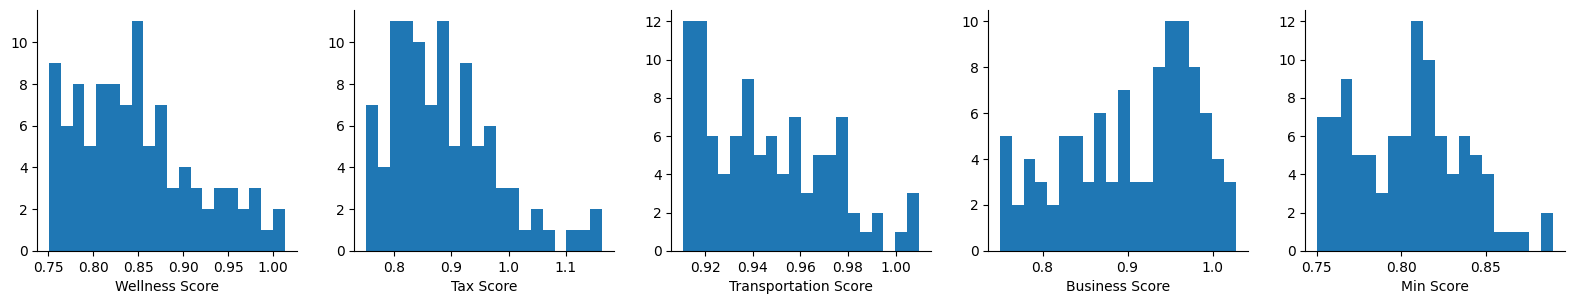

<Figure size 640x480 with 0 Axes>

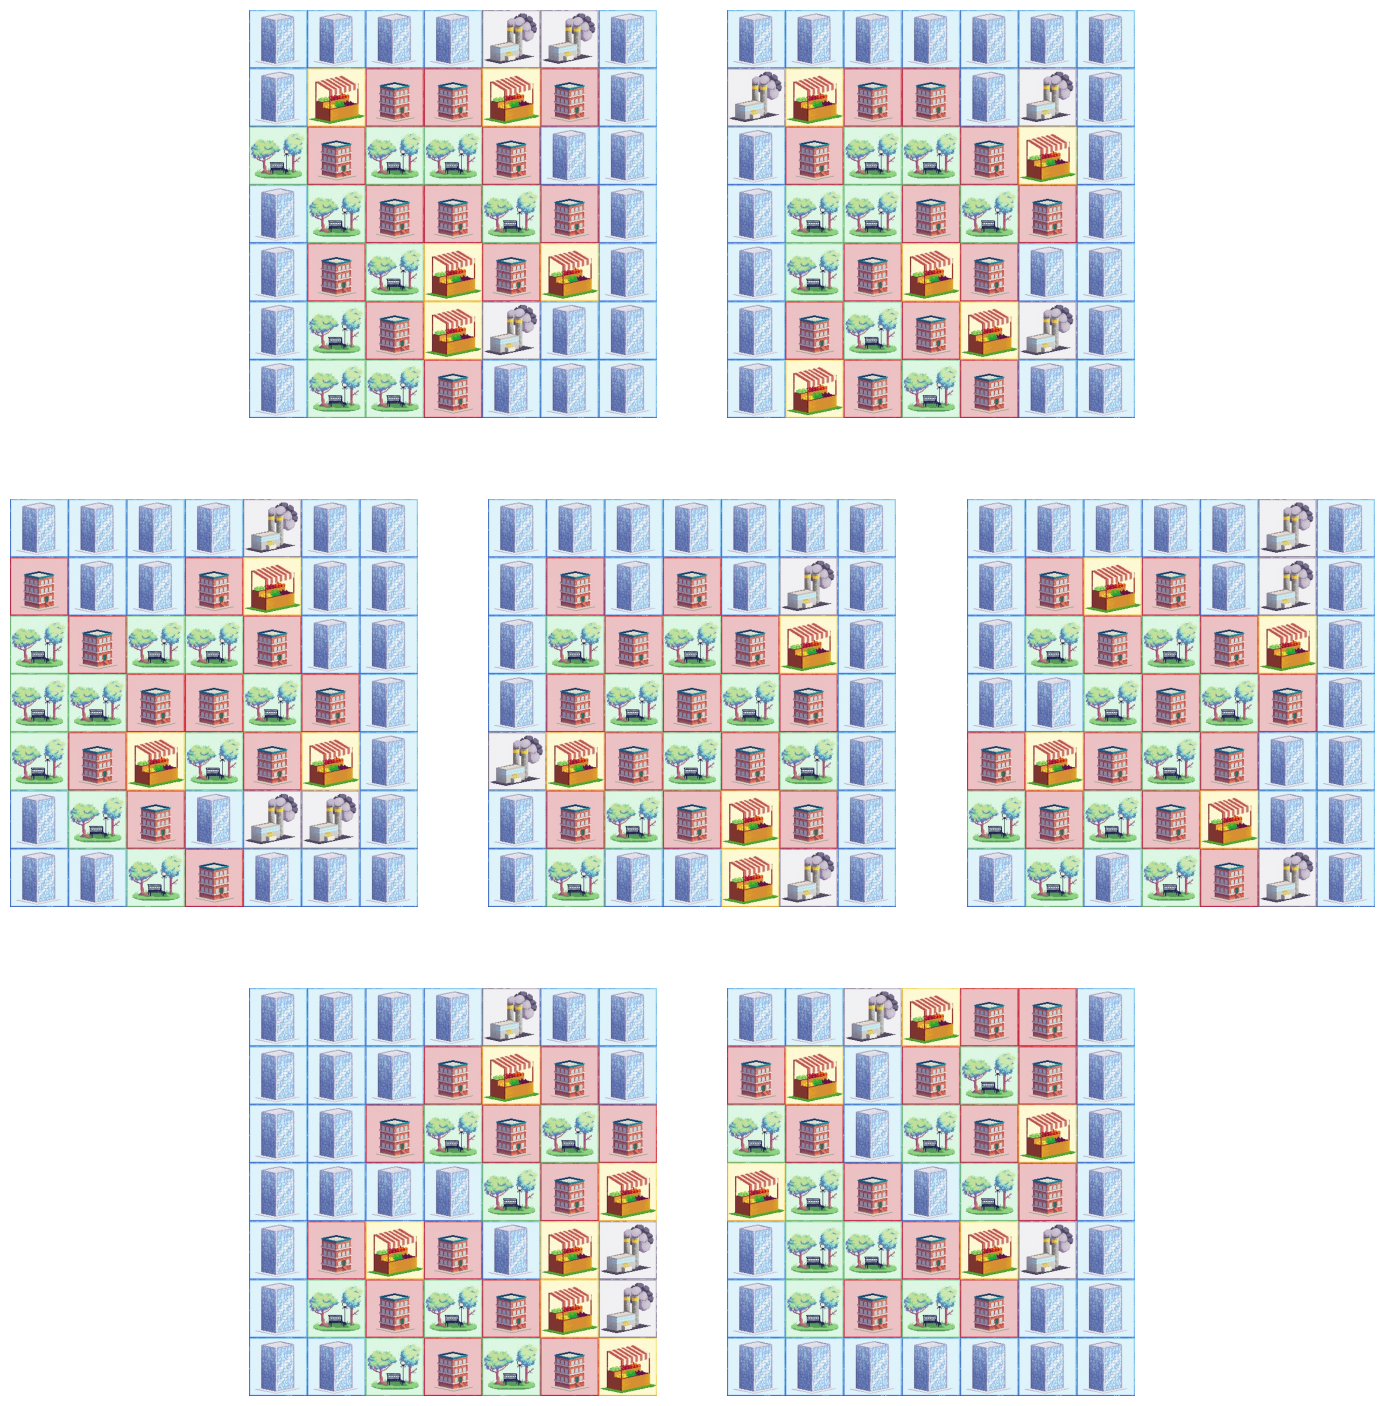

In [ ]:
# TODO pick new grids if these are invalid, find a better way to pick grids
all_predictions_array = np.load("all_predictions.npy")
min_predictions = np.min(all_predictions_array, axis=1) #minimum advisor score (as predicted)
valid_grids = np.sum(min_predictions>0.75) #number of valid grids (as predicted)
valid_indices = np.where(min_predictions > 0.75)[0] # Find indices of grids with min_predictions > 0.75 (valid grids)
# top_100_indices = np.argpartition(min_predictions, -100)[-100:] #indices of top 100 designs (as sorted by minimum advisor score)
# top_100_grids = grids[top_100_indices] #get the top 100 grids

# Get advisor 2 scores for valid grids (since this is the worst model, need max scores to have best chance of truly valid grids)
advisor2_scores = all_predictions_array[valid_indices, 2]
# Find indices of top 100 advisor 2 scores among valid grids
top_100_indices = valid_indices[np.argpartition(advisor2_scores, -100)[-100:]]
top_100_grids = grids[top_100_indices] # Get the corresponding grids


print(f"Number of valid grids (as predicted): {valid_grids}")
if valid_grids >= 100:
    score = diversity_score(top_100_grids)
    print(f"Current diversity score: {score:.4f}")

    best_submission = np.load("submission.npy")
    loaded_score = diversity_score(best_submission)
    if score > loaded_score:
        final_submission = grids[top_100_indices].astype(int)
        id = np.random.randint(1e8, 1e9-1)
        np.save(f"{id}.npy", final_submission) # uncomment this for real submission
        np.save(f"submission.npy", final_submission) 
        print(f"Score improved! Previous best: {loaded_score:.4f}")
        print("Submission saved")
    elif score <= loaded_score:
        print(f"No improvement. Previous best: {loaded_score:.4f}")
else:
    print("Not enough valid grids found")

plot_ratings_histogram(all_predictions_array[top_100_indices], withmin=True) #plot histograms of top 100 designs
plot_n_grids(top_100_grids[-7:])